Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2601 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 328ms/step - accuracy: 0.5515 - loss: 0.7584 - val_accuracy: 0.7200 - val_loss: 0.6289 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - accuracy: 0.6832 - loss: 0.6663 - val_accuracy: 0.7300 - val_loss: 0.5876 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - accuracy: 0.6918 - loss: 0.6561 - val_accuracy: 0.7500 - val_loss: 0.5869 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 268ms/step - accuracy: 0.7165 - loss: 0.6302 - val_accuracy: 0.7700 - val_loss: 0.5580 - learning_rate: 1.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 270ms/step - accuracy: 0.7093 - loss: 0.6217 - val_accuracy: 0.7300

🔥 Final Training Accuracy: 73.36%
📊 Final Validation Accuracy: 74.00%
🧪 Final Testing Accuracy: 86.67%
❗ Final Loss: 0.4600
✅ Model Saved Successfully in H5 Format!


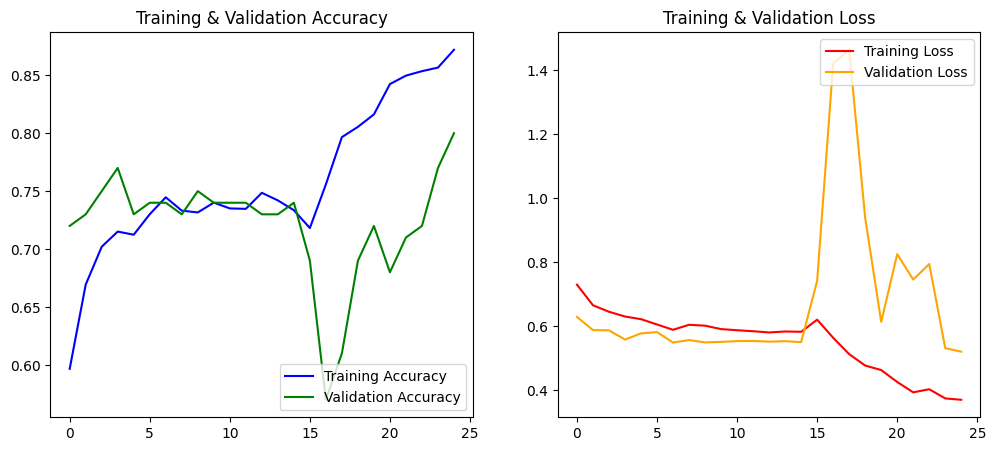

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from google.colab import drive

# ---------------- STEP 1: Mount Google Drive ----------------
drive.mount('/content/drive')

# Dataset paths
train_dir = "/content/drive/MyDrive/D2/train"
val_dir = "/content/drive/MyDrive/D2/valid"
test_dir = "/content/drive/MyDrive/D2/test"

# ---------------- STEP 2: Data Preprocessing ----------------
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load dataset
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=16, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=16, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=16, class_mode='binary')

# ---------------- STEP 3: Load Pretrained MobileNetV2 ----------------
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Custom Head with Improved Architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.00005))(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.00005))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.00005))(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(0.00005))(x)  # Extra layer for better learning
predictions = Dense(1, activation="sigmoid")(x)

# Define model
model = Model(inputs=base_model.input, outputs=predictions)

# ---------------- STEP 4: Learning Rate Scheduler ----------------
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return 0.0001
    elif epoch < 10:
        return 0.00005
    else:
        return 0.00001

lr_callback = LearningRateScheduler(lr_scheduler)

# ---------------- STEP 5: Compile & Train ----------------
model.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[lr_callback])

# ---------------- STEP 6: Fine-Tune Model ----------------
base_model.trainable = True  # Unfreeze layers

# Reduce learning rate for fine-tuning
model.compile(optimizer=AdamW(learning_rate=0.00001, weight_decay=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

history_finetune = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[lr_callback])

# ---------------- STEP 7: Evaluate Model ----------------
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_acc = model.evaluate(test_generator)

print(f"🔥 Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"📊 Final Validation Accuracy: {val_acc * 100:.2f}%")
print(f"🧪 Final Testing Accuracy: {test_acc * 100:.2f}%")
print(f"❗ Final Loss: {test_loss:.4f}")

# ---------------- STEP 8: Save Model in H5 Format ----------------
model.save("/content/drive/MyDrive/mobilenetv2_autism_model_improved.h5")
print("✅ Model Saved Successfully in H5 Format!")

# ---------------- STEP 9: Plot Graphs ----------------
def plot_training_history(history, history_finetune):
    acc = history.history['accuracy'] + history_finetune.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
    loss = history.history['loss'] + history_finetune.history['loss']
    val_loss = history.history['val_loss'] + history_finetune.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='red')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.show()

plot_training_history(history, history_finetune)
